In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 150
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
import lightning as L
import torchattacks
from torchattacks import VANILA, FGSM, PGD, JSMA, DeepFool

# from Definitions_TSRD
from Definitions_TSRD import T, DATA_PATH, MODELS_PATH, FIGURES_PATH, NUM_CLASSES, RANDOM_SEED
from Definitions_TSRD import TEACHER_TO_STUDENTS
from Definitions_TSRD import NORMALIZE_MEAN, NORMALIZE_STD
from Definitions_TSRD import FullNetwork, ReducedNetwork
from Definitions_TSRD import TeacherModel, StudentModel
from Definitions_TSRD import parse_teacher_str, parse_student_str
from Definitions_TSRD import recover_trained_weights
from Definitions_TSRD import get_TSRD_loaders, denormalize_imgs
print(f"T = {T}")
print(f"RANDOM_SEED = {RANDOM_SEED}")

# seeding
L.seed_everything(RANDOM_SEED, workers=True)
torch.manual_seed(RANDOM_SEED)

# device info
device = torch.device("cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
print(f"device = {device}")

Seed set to 42


T = 20
RANDOM_SEED = 42
device = mps


<font size=7><b>CPSC471 Project: Robustness Evaluation (TSRD)</b></font>

**Ruomu (Felix) Zou**

Here we evaluate the adversarial robustness of all the teacher/student networks.

**Model naming conventions:**
* `{F,R}T_temp{1,T}`: The *{full (larger architecture), reduced (smaller architecture)}* teacher model trained with cross-entropy with softmax temperature *{$1$, $T$ ($T>1$)}*. NOTE: Soft labels are ALWAYS generated with temperatuer $T$ regardless of teacher training temperature.
* `{F,R}S_temp{1,T}_from_{F,R}T_temp{1,T}`: Given a *{full, reduced}* teacher model trained at temperature *{$1$, $T$}*, generate soft labels at temperature $T$ and train a *{full, reduced}* student model at temperature *{$1$, $T$}*.
* Examples:
    * `FS_tempT_from_FT_tempT` represents the student model of the DD paper.
    * `RS_tempT_from_FT_temp1` represents the student model of traditional (Hinton) knowledge distillation.
    * `{F,R}S_temp1_from_{F,R}T_temp1` represents distillation where the only application of temperature is during soft label generation.
    * `{F,R}S_temp1_from_{F,R}T_tempT` represents something unconventional and weird.

# Constants and Configurations:

In [2]:
# inference-specific constants and configurations
BATCH_SIZE = 100

attack_to_name = {
    VANILA:"No Attack",
    FGSM: "Fast Gradient Sign Method",
    PGD: "Projected Gradient Descent",
    JSMA: "Jacobian Saliency Map Attack",
    DeepFool: "Deep Fool"
}

attack_to_name_reduced = {
    VANILA:"No Attack",
    FGSM: "FGSM",
    PGD: "PGD",
    JSMA: "JSMA",
    DeepFool: "DeepFool"
}

# Helper Functions:

In [3]:
def attack_image_and_plot(model_str, attack_method_class, image_idx, dataloader, strong_attack=False):
    """Evaluate the performance of the given model's trained network on the given attack method.

    NOTE: Assumes that the model corresponding to the passed string has been trained and saved already!

    Args:
        model_str: str representing the model.
        attack_method_class: torchattacks attack class.
        image_idx: int, index of the image to attack and plot.
        dataloader: dataloader from which to draw attack images.
        strong_attack: whether to divide the logits by temperature as proposed in CW to counter DD.
    Returns:
        None, displays plot.
    """
    # recover weights
    network = recover_trained_weights(model_str)

    # if using CW's strong attacks, wrap original module to divide logits by T
    if strong_attack:
        class HighTempInferenceWrapper(nn.Module):
            def __init__(self, base_module, inference_temperature):
                super().__init__()
                self.base_module = base_module
                self.inference_temperature = inference_temperature
            def forward(self, x):
                # Just divide base_module's logits by inference_temperature
                return self.base_module(x) / self.inference_temperature
        temp_to_use = T if model_str[7] == "T" else 1
        network = HighTempInferenceWrapper(network, temp_to_use).eval()

    # get image to attack
    img, label = dataloader.dataset[image_idx]
    img = img.unsqueeze(0)
    label = torch.Tensor([label,]).to(int)
    label_name = trainloader.dataset.classes[label]

    # pass clean image through network
    pred = network(img).argmax(-1).item()
    pred_name = trainloader.dataset.classes[pred]

    # get attack
    attack = attack_method_class(network)
    attack.set_normalization_used(mean=[NORMALIZE_MEAN,NORMALIZE_MEAN,NORMALIZE_MEAN],
                                  std=[NORMALIZE_STD,NORMALIZE_STD,NORMALIZE_STD])

    # generate adversarial image and pass through network
    img_adv = attack(img, label)
    pred_adv = network(img_adv).argmax(-1).item()
    pred_adv_name = trainloader.dataset.classes[pred_adv]
    
    # plot
    fig, ax = plt.subplots(1,2,figsize=(10, 6))
    ax[0].imshow(denormalize_imgs(img).squeeze().permute(1,2,0))
    ax[0].set_title(f"Clean Image (Predicted Class '{pred_name}')")
    ax[1].imshow(denormalize_imgs(img_adv).squeeze().permute(1,2,0))
    ax[1].set_title(f"Attacked Image (Predicted Class '{pred_adv_name}')")
    plt.suptitle(f"Image {image_idx} (Label '{label_name}') Attacked Using {attack_to_name[attack_method_class]} {'(CW Strong Version)' if strong_attack else '(Weak Version)'}",
                 fontsize=15, fontweight="bold")
    plt.tight_layout()
    plt.show()

def attack_and_evaluate(model_str, attack_method_class, dataloader, strong_attack=False, topk=1, max_batches=None):
    """Evaluate the performance of the given model's trained network on the given attack method.

    NOTE: Assumes that the model corresponding to the passed string has been trained and saved already!

    Args:
        model_str: str representing the model.
        attack_method_class: torchattacks attack class.
        dataloader: dataloader from which to draw attack images.
        strong_attack: whether to divide the logits by temperature as proposed in CW to counter DD.
        topk: top k used for accuracy.
        max_batches: if None, generate adversarial images for whole dataloader. Otherwise only go for
                     specified number of batches.
    Returns:
        Int, the accuracy of the model's network on the attacked dataloader.
    """
    # recover weights
    network = recover_trained_weights(model_str)

    # if using CW's strong attacks, wrap original module to divide logits by T
    if strong_attack:
        class HighTempInferenceWrapper(nn.Module):
            def __init__(self, base_module, inference_temperature):
                super().__init__()
                self.base_module = base_module
                self.inference_temperature = inference_temperature
            def forward(self, x):
                # Just divide base_module's logits by inference_temperature
                return self.base_module(x) / self.inference_temperature
        temp_to_use = T if model_str[7] == "T" else 1
        network = HighTempInferenceWrapper(network, temp_to_use).eval()

    # get attack
    attack = attack_method_class(network)
    attack.set_normalization_used(mean=[NORMALIZE_MEAN,NORMALIZE_MEAN,NORMALIZE_MEAN],
                                  std=[NORMALIZE_STD,NORMALIZE_STD,NORMALIZE_STD])

    # get accuracy metric
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, top_k=topk)

    # loop through and evaluate each batch
    batch_accuracies = []
    torch.manual_seed(RANDOM_SEED)
    for i, (imgs, labels) in enumerate(dataloader):
        # make sure network is still in eval
        network.eval()
        
        # stop if exceeded max_batches
        if max_batches is not None and i+1 > max_batches:
            break

        # generate adversarial images and pass through network
        imgs_adv = attack(imgs, labels)
        probs_adv = F.softmax(network(imgs_adv), dim=-1)

        # calculate topk accuracy and add to list
        batch_accuracies.append(metric(probs_adv, labels).item())

    # return the mean of the batch accuracies
    return sum(batch_accuracies) / len(batch_accuracies)

def evaluate_all_models(attacks, dataloader, topk=1, max_batches=None):
    """Wrapper for attack_and_evaluate to run on all models."""
    # loop through all teachers
    for teacher, students in TEACHER_TO_STUDENTS.items():
        # first print a single line with all the model names
        print(f"{f'{teacher}:' : <25}", end="")
        for student in students:
            print(f"{f'{student}:' : <25}",end="")
        print() # newline

        # then print one line for each attack
        for attack in attacks:
            
            # attack teacher with weak attack
            acc = attack_and_evaluate(teacher, attack, dataloader, False, topk, max_batches)
            print(f"{f'  * {attack_to_name_reduced[attack]}: {round(acc*100, 2)}%' : <25}",end="")
            # attack all students with weak attack
            for student in students:
                acc = attack_and_evaluate(student, attack, dataloader, False, topk, max_batches)
                print(f"{f'  * {attack_to_name_reduced[attack]}: {round(acc*100, 2)}%' : <25}",end="")
            print() # newline

            if attack is not VANILA:
                # attack teacher again with strong attack
                acc = attack_and_evaluate(teacher, attack, dataloader, True, topk, max_batches)
                print(f"{f'  * {attack_to_name_reduced[attack]} (CW): {round(acc*100, 2)}%' : <25}",end="")
                # attack all students again with strong attack
                for student in students:
                    acc = attack_and_evaluate(student, attack, dataloader, True, topk, max_batches)
                    print(f"{f'  * {attack_to_name_reduced[attack]} (CW): {round(acc*100, 2)}%' : <25}",end="")
                print() # newline
            
        print() # newline

# Execution

# Get data:

In [4]:
trainloader, testloader = get_TSRD_loaders(BATCH_SIZE)

## Evaluate all networks:

In [5]:
# max_batches = 3
# print(f"{f'Attacking All Models on the Training Dataset Using Random Sample of {BATCH_SIZE*max_batches} Datapoints (Top 3 Accuracy)' : ^20}\n")
# evaluate_all_models(attacks=[VANILA], dataloader=trainloader, topk=3, max_batches=max_batches)

Attacking All Models on the Training Dataset Using Random Sample of 300 Datapoints (Top 3 Accuracy)

RT_temp1:                RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
  * No Attack: 99.33%      * No Attack: 97.0%       * No Attack: 89.0%       * No Attack: 91.0%       * No Attack: 83.67%    

FT_temp1:                RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
  * No Attack: 99.33%      * No Attack: 92.33%      * No Attack: 88.67%      * No Attack: 85.67%      * No Attack: 87.33%    

RT_tempT:                RS_temp1_from_RT_tempT:  FS_temp1_from_RT_tempT:  RS_tempT_from_RT_tempT:  FS_tempT_from_RT_tempT:  
  * No Attack: 96.33%      * No Attack: 95.33%      * No Attack: 94.33%      * No Attack: 91.67%      * No Attack: 93.67%    

FT_tempT:                RS_temp1_from_FT_tempT:  FS_temp1_from_FT_tempT:  RS_tempT_from_FT_tempT:  FS_tempT_from_FT_tempT:  
  * No Attack:

In [6]:
# max_batches = 3
# print(f"{f'Attacking All Models on the Testing Dataset Using Random Sample of {BATCH_SIZE*max_batches} Datapoints (Top 3 Accuracy)' : ^20}\n")
# evaluate_all_models(attacks=[VANILA, FGSM, PGD], dataloader=testloader, topk=3, max_batches=max_batches)

Attacking All Models on the Testing Dataset Using Random Sample of 300 Datapoints (Top 3 Accuracy)

RT_temp1:                RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
  * No Attack: 80.67%      * No Attack: 68.67%      * No Attack: 60.0%       * No Attack: 60.67%      * No Attack: 59.33%    
  * FGSM: 44.0%            * FGSM: 43.33%           * FGSM: 35.33%           * FGSM: 35.33%           * FGSM: 32.67%         
  * FGSM (CW): 44.0%       * FGSM (CW): 43.33%      * FGSM (CW): 35.33%      * FGSM (CW): 36.67%      * FGSM (CW): 32.67%    
  * PGD: 31.33%            * PGD: 23.67%            * PGD: 23.0%             * PGD: 24.67%            * PGD: 30.0%           
  * PGD (CW): 31.33%       * PGD (CW): 23.67%       * PGD (CW): 23.0%        * PGD (CW): 24.67%       * PGD (CW): 29.33%     

FT_temp1:                RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
  * No Attack: 86

Attacking All Models on the Testing Dataset Using Random Sample of 300 Datapoints (Top 3 Accuracy)

RT_temp1:                RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
  * No Attack: 80.67%      * No Attack: 68.67%      * No Attack: 60.0%       * No Attack: 60.67%      * No Attack: 59.33%    
  * FGSM: 44.0%            * FGSM: 43.33%           * FGSM: 35.33%           * FGSM: 35.33%           * FGSM: 32.67%         
  * FGSM (CW): 44.0%       * FGSM (CW): 43.33%      * FGSM (CW): 35.33%      * FGSM (CW): 36.67%      * FGSM (CW): 32.67%    
  * PGD: 31.33%            * PGD: 23.67%            * PGD: 23.0%             * PGD: 24.67%            * PGD: 30.0%           
  * PGD (CW): 31.33%       * PGD (CW): 23.67%       * PGD (CW): 23.0%        * PGD (CW): 24.67%       * PGD (CW): 29.33%     

FT_temp1:                RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
  * No Attack: 86.0%       * No Attack: 76.67%      * No Attack: 70.0%       * No Attack: 70.67%      * No Attack: 63.33%    
  * FGSM: 53.33%           * FGSM: 46.0%            * FGSM: 40.0%            * FGSM: 38.67%           * FGSM: 40.67%         
  * FGSM (CW): 53.33%      * FGSM (CW): 46.0%       * FGSM (CW): 40.0%       * FGSM (CW): 38.67%      * FGSM (CW): 39.67%    
  * PGD: 40.33%            * PGD: 19.0%             * PGD: 28.33%            * PGD: 31.67%            * PGD: 33.33%          
  * PGD (CW): 40.33%       * PGD (CW): 19.0%        * PGD (CW): 28.33%       * PGD (CW): 22.33%       * PGD (CW): 27.67%     

RT_tempT:                RS_temp1_from_RT_tempT:  FS_temp1_from_RT_tempT:  RS_tempT_from_RT_tempT:  FS_tempT_from_RT_tempT:  
  * No Attack: 62.67%      * No Attack: 69.33%      * No Attack: 56.67%      * No Attack: 63.33%      * No Attack: 62.0%     
  * FGSM: 47.33%           * FGSM: 44.67%           * FGSM: 36.33%           * FGSM: 44.67%           * FGSM: 47.33%         
  * FGSM (CW): 34.33%      * FGSM (CW): 44.67%      * FGSM (CW): 36.33%      * FGSM (CW): 38.67%      * FGSM (CW): 36.33%    
  * PGD: 35.33%            * PGD: 32.67%            * PGD: 27.33%            * PGD: 36.0%             * PGD: 43.0%           
  * PGD (CW): 28.33%       * PGD (CW): 32.67%       * PGD (CW): 27.33%       * PGD (CW): 30.67%       * PGD (CW): 24.67%     

FT_tempT:                RS_temp1_from_FT_tempT:  FS_temp1_from_FT_tempT:  RS_tempT_from_FT_tempT:  FS_tempT_from_FT_tempT:  
  * No Attack: 87.33%      * No Attack: 86.0%       * No Attack: 85.33%      * No Attack: 69.33%      * No Attack: 79.33%    
  * FGSM: 60.0%            * FGSM: 41.33%           * FGSM: 44.67%           * FGSM: 49.33%           * FGSM: 60.67%         
  * FGSM (CW): 38.0%       * FGSM (CW): 41.33%      * FGSM (CW): 44.67%      * FGSM (CW): 39.67%      * FGSM (CW): 40.67%    
  * PGD: 54.67%            * PGD: 27.0%             * PGD: 32.33%            * PGD: 40.0%             * PGD: 55.0%           
  * PGD (CW): 30.33%       * PGD (CW): 27.0%        * PGD (CW): 32.33%       * PGD (CW): 33.67%       * PGD (CW): 32.67%   

## Single image examples:

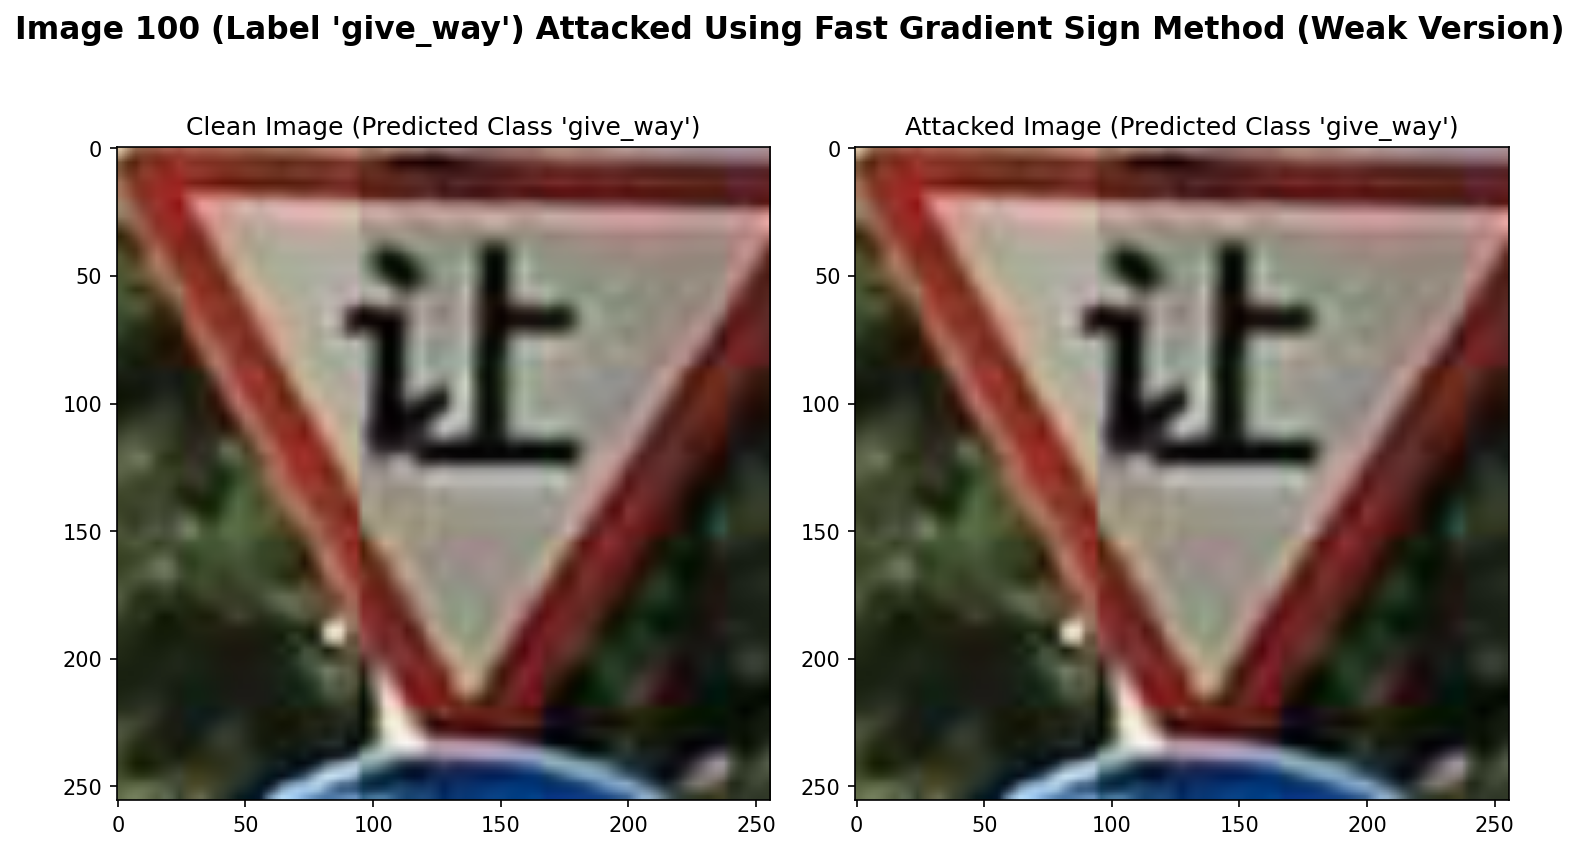

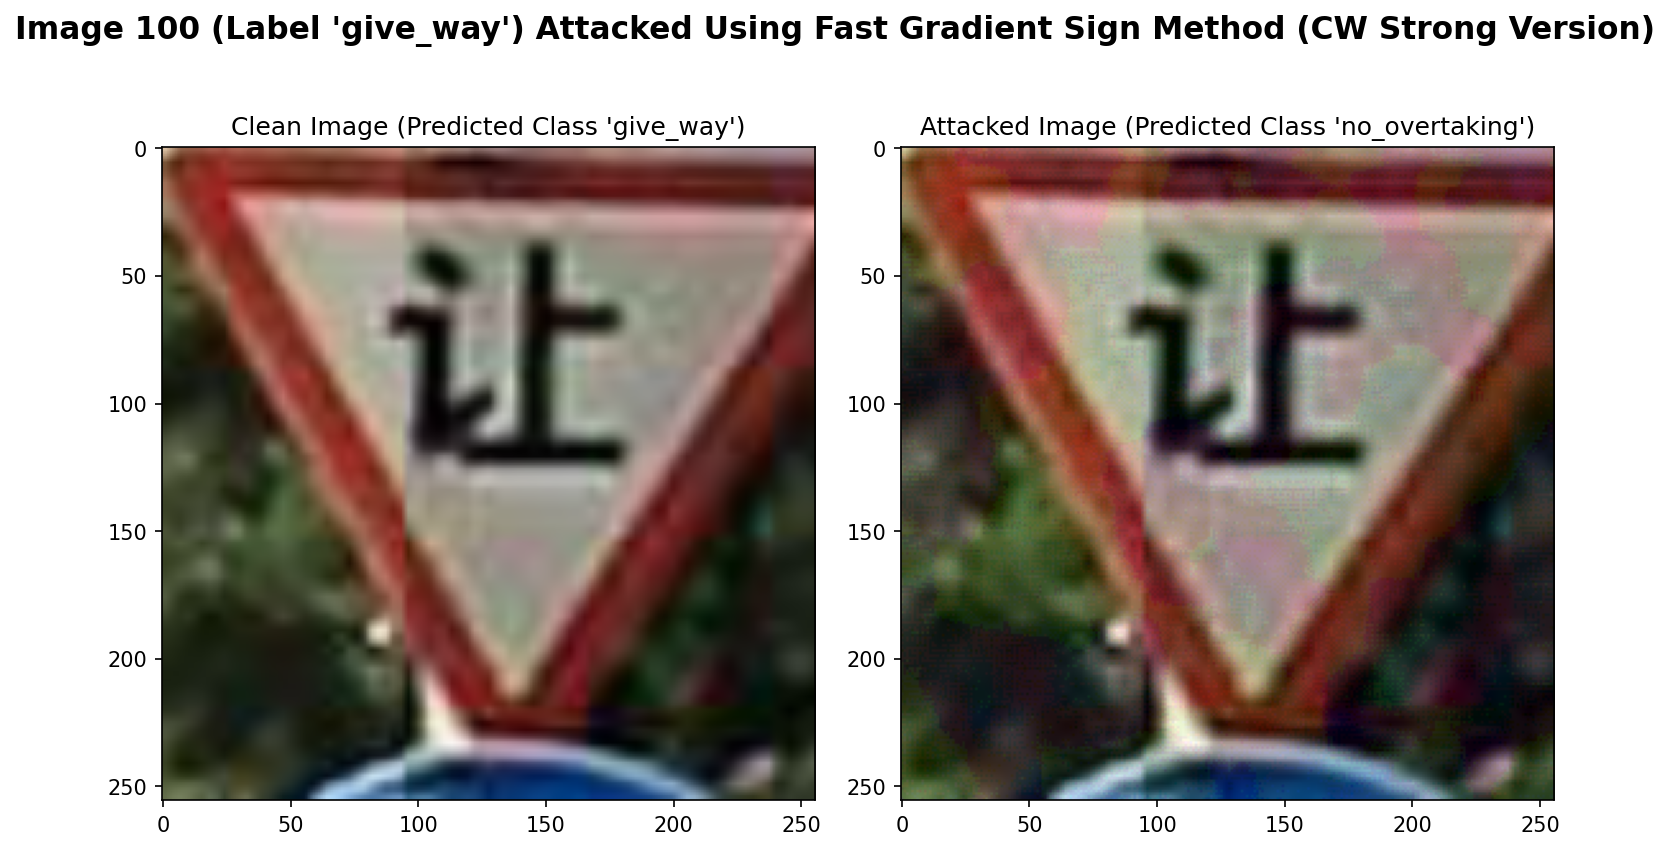

In [7]:
attack_image_and_plot("FS_tempT_from_FT_tempT", FGSM, 100, testloader, strong_attack=False)
attack_image_and_plot("FS_tempT_from_FT_tempT", FGSM, 100, testloader, strong_attack=True)